In [ ]:
# 4 inner channel with/out ReLU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/My Drive/data/')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from PIL import Image
from torchvision import transforms

import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests
from io import BytesIO

In [ ]:
###### generating original Gaussian kernel
r=33
sigma1 = 4

mean1 = -3 

sigma2 = 4
mean2 = 7

x = np.arange(-15, 15 + 1)
x1 = np.exp(-(x-mean1)**2/(2*sigma1**2))
x1 = x1[np.newaxis,:] * x1[:,np.newaxis]
x1 = x1 / x1.sum()
x2 = np.exp(-(x-mean2)**2/(2*sigma2**2))
x2 = x2[np.newaxis,:] * x2[:,np.newaxis]
x2 = x2 / x2.sum()

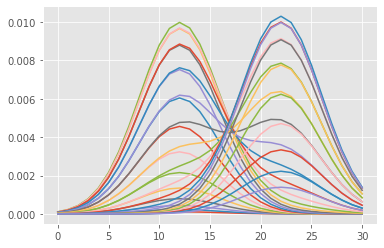

In [ ]:
plt.plot(x1+x2)

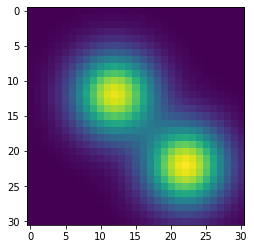

In [ ]:
plt.imshow(x1+x2)

In [ ]:
class Gauss_func(object):
    
    def __init__(self, kernel_size=33):
        radias = kernel_size // 2
        kernel_size = radias * 2 + 1
        self.gauss_u = nn.Conv2d(1, 1, kernel_size=(kernel_size, kernel_size),padding=(16,16),padding_mode='replicate', bias=False, groups=1) # padding=(16,16)
        self.gauss_v = nn.Conv2d(1, 1, kernel_size=(kernel_size, kernel_size),padding=(16,16),padding_mode='replicate',bias=False, groups=1) #padding_mode='replicate'
        self.k = kernel_size
        self.r = radias

        self.tensor_to_pil = transforms.ToPILImage()

    def __call__(self, img):
        img = torch.tensor(np.asarray(img)).unsqueeze(0).float()
        img=img.unsqueeze(0).float() 
        img = img.permute(0, 1, 2, 3)

        sigma1 = 4
        mean1 = -3

        sigma2 = 4
        mean2 = 7

        x = np.arange(-self.r, self.r + 1)
        x1 = np.exp(-(x-mean1)**2/(2*sigma1**2))
        x1 = x1[np.newaxis,:] * x1[:,np.newaxis]
        x1 = x1 / x1.sum()

        x2 = np.exp(-(x-mean2)**2/(2*sigma2**2))
        x2 = x2[np.newaxis,:] * x2[:,np.newaxis]
        x2 = x2 / x2.sum()

        x1 = torch.from_numpy(x1)
        x2 = torch.from_numpy(x2)

        self.gauss_u.weight.data.copy_(x1.view(1, 1, self.k, self.k))
        self.gauss_v.weight.data.copy_(x2.view(1, 1, self.k, self.k))

        with torch.no_grad():
            img1 = self.gauss_u(img)
            img2 = self.gauss_v(img)
            img = 0.5*(img1+img2).squeeze()


          
        return img

In [ ]:
### This block of codes is given from \cite{}, except the Gaussian blur function
## sub images generation along with the blurred labels

import os
import glob
import h5py
import cv2
from PIL import Image
import numpy as np

def mod_crop(image, scale = 3):
    if len(image.shape) ==3:
        h = image.shape[0]
        w = image.shape[1]
        h = h - np.mod(h,scale)
        w = w - np.mod(w,scale)
        return image[0:h,0:w,:]
    else:
        h = image.shape[0]
        w = image.shape[1]
        h = h - np.mod(h,scale)
        w = w - np.mod(w,scale)
        return image[0:h,0:w]

def sub_img(input, label, i_size = 66, l_size = 66, stride = 14):
    sub_ipt = []
    sub_lab = []
    pad = abs(i_size-l_size)//2

    for h in range(0, input.shape[0] - i_size + 1, stride):
        for w in range(0, input.shape[1] - l_size + 1, stride):
            sub_i = input[h:h+i_size,w:w+i_size]
            sub_l = label[h + pad :h + pad + l_size,w + pad :w + pad + l_size]
            sub_i = sub_i.reshape(1, i_size,i_size)
            sub_l = sub_l.reshape(1, l_size,l_size)
            sub_ipt.append(sub_i)
            sub_lab.append(sub_l)
    return sub_ipt, sub_lab

def load_img(file_path):
    dir_path = os.path.join(os.getcwd(), file_path)
    img_path = glob.glob(os.path.join(dir_path, '*.bmp'))
    return img_path

def read_img(img_path):
    # read image
    image = cv2.imread(img_path)
    # rgb > ycbcr
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
    image = image[:, :, 0]
    return image

def GB_img(img, scale): 
    label = img.astype('float') / 255
    input= Gauss_func()(label)
    input=input.numpy()
    return input, label

def img_rotate(img, degree):
    height, width = img.shape
    matrix = cv2.getRotationMatrix2D((width/2, height/2), 90*degree, 1)
    if degree == 1 or degree == 3:
        dst = cv2.warpAffine(img, matrix, (height, width))
    else:
        dst = cv2.warpAffine(img, matrix, (width, height))
    return dst

def save_h5(sub_ip, sub_la, savepath = '/content/drive/My Drive/data/sub_imgs2.h5'):
    path = os.path.join(os.getcwd(), savepath)
    with h5py.File(path, 'w') as hf:
        hf.create_dataset('input', data=sub_ip)
        hf.create_dataset('label', data=sub_la)

def data_aug(file_path = '/content/drive/My Drive/data/Train', savepath = '/content/drive/My Drive/data/sub_imgs2.h5', i_size = 66, l_size = 66, stride = 14):
    sub_ip = []
    sub_la = []
    num = 1
    img_path = load_img(file_path)
    for _ in img_path:
        image = read_img(_)
        for degree in [0.,1.,2.]:
            image_r = img_rotate(image, degree)
            for scale in [2,3]:
                md_image = mod_crop(image_r, scale)
                input, label = GB_img(md_image, scale)
                sub_ipt, sub_lab = sub_img(input, label, i_size, l_size, stride)
                sub_ip += sub_ipt
                sub_la += sub_lab
        print('data no.',num)
        num += 1
    sub_ip = np.asarray(sub_ip)
    sub_la = np.asarray(sub_la)
    print('input shape : ',sub_ip.shape)
    print('label shape0* : ',sub_la.shape)
    save_h5(sub_ip, sub_la, savepath)
    print('---------save---------')

if __name__ == '__main__':
    print('starting data augmentation...')
    data_aug()

In [ ]:
def data_patch_example(file_path = '/content/drive/My Drive/data/Train', 
i_size = 66, l_size = 66, stride = 14):
    sub_ip = []
    sub_la = []
    num = 1
    img_path = load_img(file_path)
    for _ in img_path:
        if num>1:
          continue
        image = read_img(_)
        for degree in [0.]: #,1.,2.,3.]:
            image_r = img_rotate(image, degree)
            for scale in [2]: #,3,4]:
                md_image = mod_crop(image_r, scale)
                input, label = GB_img(md_image, scale)
                sub_ipt, sub_lab = sub_img(input, label, i_size, l_size, stride)
                sub_ip.append(sub_ipt)
                sub_la.append(sub_lab)
        print('data no.',num)
        num += 1
    sub_ip = np.asarray(sub_ip)
    sub_la = np.asarray(sub_la)

    return sub_ip, sub_la

a,b= data_patch_example(file_path = '/content/drive/My Drive/data/Train')

data no. 1


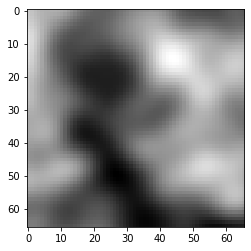

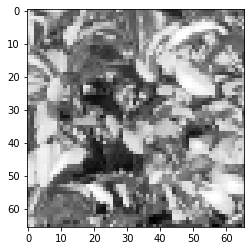

In [ ]:
b.shape

plt.imshow(a[0,0,0],cmap="gray")
plt.show()
plt.imshow(b[0,0,0],cmap="gray")
plt.show()

In [ ]:
### 2 layer CNN with 4 inner channels
class Anet(nn.Module): 
    def __init__(self,  channel=4):
        super(Anet, self).__init__()
        self.channel=channel
        self.conv1 = nn.Conv2d(1, self.channel, kernel_size=(33,1),padding=(16,0),padding_mode='replicate', bias=False, groups=1) 
        self.conv2 = nn.Conv2d(self.channel, 1, kernel_size=(1,33), padding=(0,16),padding_mode='replicate',bias=False, groups=1)
    def forward(self, x):
        x1 =self.conv1(x)
        #x2 = F.relu(self.conv2(x1)) #### here add ReLU layer!!!!!
        x2 = self.conv2(x1)

        U = A_net.conv1.weight.detach().clone()  ### first conv kernel
        V = A_net.conv2.weight.detach().clone()  ### second conv kernel
        return x2,x1,U,V
A_net = Anet().to(device)
print(A_net)

In [ ]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import time
import h5py
import torch.optim as optim
import torch.nn as nn
import numpy as np
import math
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

In [ ]:
# setting the model hyperparameters
batch_num=64
epochs=50
lr= 0.001 # learning step

In [ ]:
# sub-img dimensions
img_width, img_hight = 66, 66
output_width, output_hight = 66, 66

In [ ]:
Data_imgs = h5py.File('/content/drive/My Drive/data/sub_imgs2.h5')

out_train = Data_imgs['input'][:]
in_train = Data_imgs['label'][:] 
Data_imgs.close()

in_train = in_train.astype('float32')
out_train = out_train.astype('float32')

In [ ]:
(x_train, x_val, y_train, y_val) = train_test_split(in_train, out_train, test_size=0.25)

In [ ]:
# the dataset module
class AnetDataset(Dataset):
    def __init__(self, image_data, labels):
        self.image_data = image_data
        self.labels = labels
    def __len__(self):
        return (len(self.image_data))
    def __getitem__(self, index):
        image = self.image_data[index]
        label = self.labels[index]
        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float)
        )

In [ ]:
# train and validation data
train_data = AnetDataset(x_train, y_train)
val_data = AnetDataset(x_val, y_val)
# train and validation loaders
train_loader = DataLoader(train_data, batch_size=batch_num)
val_loader = DataLoader(val_data, batch_size=batch_num)

In [ ]:
model = Anet().to(device)
model

Anet(
  (conv1): Conv2d(1, 4, kernel_size=(33, 1), stride=(1, 1), padding=(16, 0), bias=False, padding_mode=replicate)
  (conv2): Conv2d(4, 1, kernel_size=(1, 33), stride=(1, 1), padding=(0, 16), bias=False, padding_mode=replicate)
)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
import math

In [ ]:
def user_loss(recon_y, y, U, V, alpha=0.0001):

    E = torch.subtract(y, recon_y)
    sumE2 = torch.sum(E.pow(2.0))
    sumU2 = torch.sum(U.pow(2.0))
    sumV2 = torch.sum(V.pow(2.0))

    obj = sumE2 + alpha*(sumU2 + sumV2) 

    return obj

In [ ]:
def train(model, dataloader):
    model.train()
    batch_loss = 0.0
    for bi, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        image_data = data[0].to(device)
        label = data[1].to(device)
        
        optimizer.zero_grad()

        x2,_, U, V  = model(image_data)

        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters()) # L2 norm of the weights
        obj=nn.MSELoss()
        loss = obj(x2, label)
        loss= loss +  0.01*l2_norm #adding L2 regularization to loss
        loss.backward()
        optimizer.step()
        batch_loss += loss.item()
    total_loss = batch_loss/len(dataloader.dataset)
    return total_loss

In [ ]:
def validate(model, dataloader, epoch):
    model.eval()
    batch_loss = 0.0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            x2,_, U, V  = model(image_data)

            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters()) 
            obj=nn.MSELoss()
            loss = obj(x2, label)
            loss= loss +  0.01*l2_norm 
            batch_loss += loss.item()
        outputs = x2.cpu()
        #save_image(outputs, f"/content/drive/My Drive/MyVal/val{epoch}.png")
        #save_image(label.cpu(), f"/content/drive/My Drive/Myref/ref{epoch}.png")

    total_loss = batch_loss/len(dataloader.dataset)
    return total_loss

In [ ]:
train_loss, val_loss = [], []

start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_epoch_loss= train(model, train_loader)
    val_epoch_loss = validate(model, val_loader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

end = time.time()
print(f"timing : {((end-start)/60):.3f} mins")

Epoch 1 of 50


1132it [00:07, 158.74it/s]
378it [00:01, 336.82it/s]                         


Epoch 2 of 50


1132it [00:07, 151.03it/s]                          
378it [00:01, 269.38it/s]                         


Epoch 3 of 50


1132it [00:06, 186.86it/s]                          
378it [00:01, 338.69it/s]                         


Epoch 4 of 50


1132it [00:06, 172.41it/s]                          
378it [00:01, 340.63it/s]                         


Epoch 5 of 50


1132it [00:06, 186.76it/s]                          
378it [00:01, 336.11it/s]                         


Epoch 6 of 50


1132it [00:06, 171.65it/s]                          
378it [00:01, 331.63it/s]                         


Epoch 7 of 50


1132it [00:06, 172.69it/s]                          
378it [00:01, 259.00it/s]


Epoch 8 of 50


1132it [00:06, 179.70it/s]                          
378it [00:01, 345.90it/s]                         


Epoch 9 of 50


1132it [00:06, 180.53it/s]                          
378it [00:01, 259.29it/s]                         


Epoch 10 of 50


1132it [00:05, 190.36it/s]                          
378it [00:01, 339.40it/s]                         


Epoch 11 of 50


1132it [00:06, 174.49it/s]                          
378it [00:01, 341.26it/s]                         


Epoch 12 of 50


1132it [00:05, 191.33it/s]                          
378it [00:01, 342.96it/s]                         


Epoch 13 of 50


1132it [00:06, 172.10it/s]                          
378it [00:01, 331.24it/s]                         


Epoch 14 of 50


1132it [00:06, 187.86it/s]                          
378it [00:01, 318.28it/s]                         


Epoch 15 of 50


1132it [00:06, 173.06it/s]                          
378it [00:01, 338.43it/s]                         


Epoch 16 of 50


1132it [00:06, 186.31it/s]                          
378it [00:01, 254.46it/s]                         


Epoch 17 of 50


1132it [00:06, 168.55it/s]                          
378it [00:01, 261.99it/s]                         


Epoch 18 of 50


1132it [00:07, 149.62it/s]                          
378it [00:01, 336.40it/s]                         


Epoch 19 of 50


1132it [00:07, 143.99it/s]                          
378it [00:04, 76.59it/s]                          


Epoch 20 of 50


1132it [00:06, 172.29it/s]                          
378it [00:02, 140.75it/s]                         


Epoch 21 of 50


1132it [00:08, 129.24it/s]                          
378it [00:01, 337.66it/s]                         


Epoch 22 of 50


1132it [00:06, 175.09it/s]                          
378it [00:01, 292.89it/s]                         


Epoch 23 of 50


1132it [00:06, 184.92it/s]                          
378it [00:01, 336.58it/s]                         


Epoch 24 of 50


1132it [00:06, 170.92it/s]                          
378it [00:01, 335.35it/s]                         


Epoch 25 of 50


1132it [00:06, 188.24it/s]                          
378it [00:01, 338.87it/s]                         


Epoch 26 of 50


1132it [00:06, 172.93it/s]                          
378it [00:01, 333.61it/s]                         


Epoch 27 of 50


1132it [00:05, 189.59it/s]                          
378it [00:01, 265.57it/s]                         


Epoch 28 of 50


1132it [00:06, 177.76it/s]                          
378it [00:01, 338.70it/s]                         


Epoch 29 of 50


1132it [00:06, 181.39it/s]                          
378it [00:01, 255.94it/s]                         


Epoch 30 of 50


1132it [00:06, 177.36it/s]                          
378it [00:01, 280.33it/s]                         


Epoch 31 of 50


1132it [00:06, 174.24it/s]                          
378it [00:01, 335.57it/s]                         


Epoch 32 of 50


1132it [00:06, 188.33it/s]                          
378it [00:01, 327.09it/s]                         


Epoch 33 of 50


1132it [00:07, 161.50it/s]                          
378it [00:01, 338.91it/s]                         


Epoch 34 of 50


1132it [00:05, 189.32it/s]                          
378it [00:01, 258.19it/s]                         


Epoch 35 of 50


1132it [00:06, 179.34it/s]                          
378it [00:01, 333.17it/s]                         


Epoch 36 of 50


1132it [00:06, 181.53it/s]                          
378it [00:01, 252.85it/s]                         


Epoch 37 of 50


1132it [00:06, 188.11it/s]                          
378it [00:01, 340.26it/s]                         


Epoch 38 of 50


1132it [00:06, 173.47it/s]
378it [00:01, 343.51it/s]                         


Epoch 39 of 50


1132it [00:05, 191.21it/s]                          
378it [00:01, 337.84it/s]                         


Epoch 40 of 50


1132it [00:06, 172.65it/s]                          
378it [00:01, 333.65it/s]                         


Epoch 41 of 50


1132it [00:05, 189.98it/s]                          
378it [00:02, 157.52it/s]                         


Epoch 42 of 50


1132it [00:06, 174.66it/s]                          
378it [00:01, 345.81it/s]                         


Epoch 43 of 50


1132it [00:06, 185.61it/s]                          
378it [00:01, 252.21it/s]                         


Epoch 44 of 50


1132it [00:06, 183.32it/s]                          
378it [00:01, 335.39it/s]                         


Epoch 45 of 50


1132it [00:06, 175.28it/s]                          
378it [00:01, 315.12it/s]                         


Epoch 46 of 50


1132it [00:06, 187.50it/s]                          
378it [00:01, 318.88it/s]                         


Epoch 47 of 50


1132it [00:06, 170.59it/s]                          
378it [00:01, 337.89it/s]                         


Epoch 48 of 50


1132it [00:06, 187.35it/s]                          
378it [00:01, 328.05it/s]                         


Epoch 49 of 50


1132it [00:06, 170.05it/s]                          
378it [00:01, 337.04it/s]                         


Epoch 50 of 50


1132it [00:06, 183.28it/s]                          
378it [00:01, 256.57it/s]                         

timing : 6.509 mins


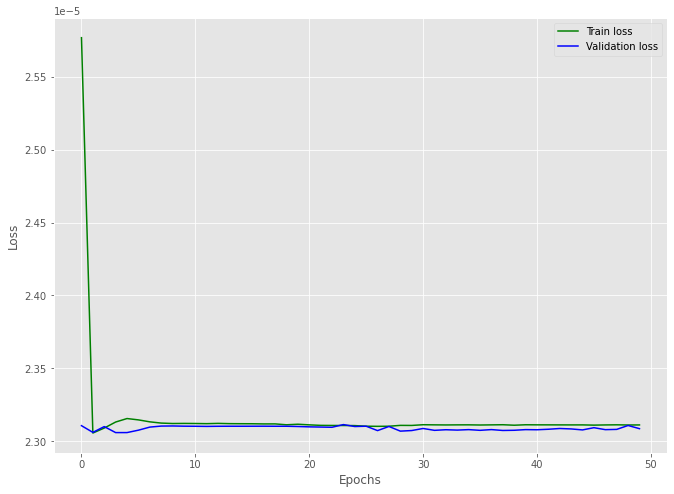

In [ ]:
# loss plots
plt.figure(figsize=(11, 8))
plt.plot(train_loss, color='green', label='Train loss')
plt.plot(val_loss, color='blue', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/content/drive/My Drive/loss.png')
plt.show()

In [ ]:

torch.save(model.state_dict(), '/content/drive/My Drive/model_update2023.pth')


In [ ]:
import torch
import cv2

import numpy as np
import glob as glob
import os
from torchvision.utils import save_image

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/My Drive/?.pth/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model = model.to(device)
model
#model=model.cpu()
#model.load_state_dict(torch.load('/content/drive/My Drive/model_update.pth'))

Anet(
  (conv1): Conv2d(1, 4, kernel_size=(33, 1), stride=(1, 1), padding=(16, 0), bias=False, padding_mode=replicate)
  (conv2): Conv2d(4, 1, kernel_size=(1, 33), stride=(1, 1), padding=(0, 16), bias=False, padding_mode=replicate)
)

In [ ]:
from google.colab.patches import cv2_imshow

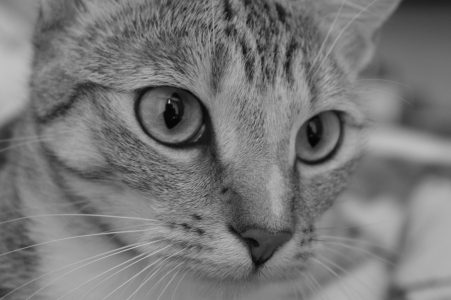

(300, 451, 1)


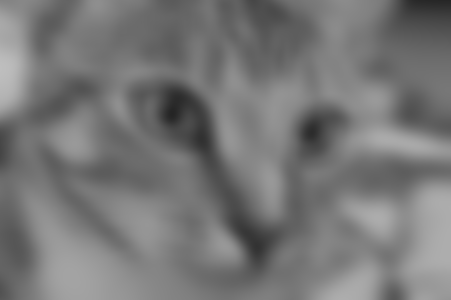

In [ ]:

image_dir = glob.glob('/content/drive/My Drive/test_chelsea/test_chelsea*')
for image_dir in image_dir:
    image = cv2.imread(image_dir, cv2.IMREAD_COLOR)
    test_image_name = image_dir.split(os.path.sep)[-1].split('.')[0]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.reshape(image.shape[0], image.shape[1], 1)
    cv2.imwrite(f"/content/drive/My Drive/cat_img.png", image)
    image = image 
    cv2_imshow(image)
    cv2.waitKey(0)
    model.eval()
    with torch.no_grad():
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        image = torch.tensor(image, dtype=torch.float).to(device)
        image = image.unsqueeze(0)
        x2,_, _,_= model(image)
        outputs = x2.cpu()
    save_image(outputs, f"/content/drive/My Drive/cat2.png")
    outputs = outputs.detach().numpy()
    outputs = outputs.reshape(outputs.shape[2], outputs.shape[3], outputs.shape[1])
    print(outputs.shape)
    cv2_imshow(outputs)
    cv2.waitKey(0)

In [ ]:
model.eval()
model.cpu
image.cpu
x2,_,U,V = model(image)

U=U.squeeze(1)
V=V.squeeze(0)
U.shape
U=U.cpu()
V=V.cpu()

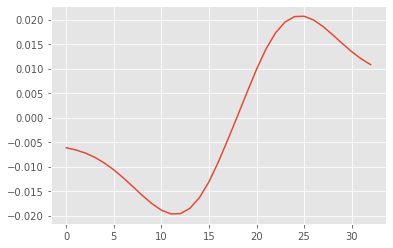

In [ ]:
U.shape

plt.plot(U[0])
#plt.plot(U[1])

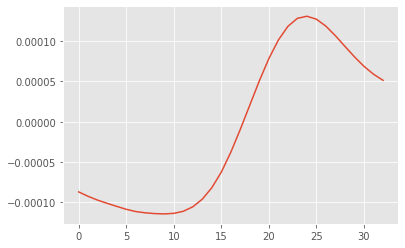

In [ ]:
plt.plot(U[3])

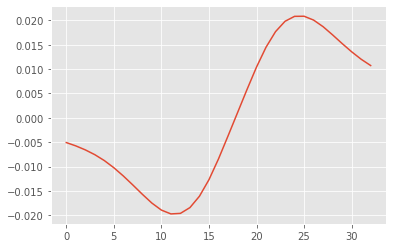

In [ ]:
plt.plot(V[0].T)

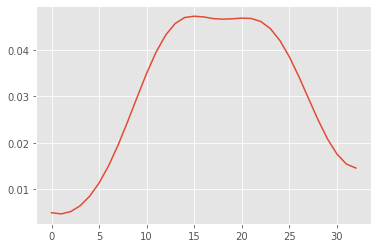

In [ ]:
plt.plot(V[1].T)

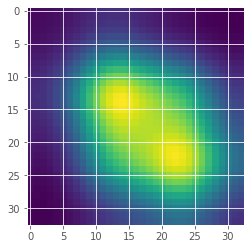

In [ ]:
X_hat = np.zeros((U[0].shape[0], V[0].shape[1]))
for i in range(4):
  X_hat = X_hat + np.outer(U[i], V[i])
plt.imshow(X_hat)

In [ ]:
UV1 = np.outer(U[0], V[0])
UV1.shape

(33, 33)

In [ ]:
UV2 = np.outer(U[1], V[1])
UV2.shape

(33, 33)

In [ ]:
UV3 = np.outer(U[2], V[2])


In [ ]:
UV4 = np.outer(U[3], V[3])
UV4.shape

(33, 33)

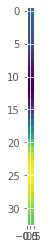

In [ ]:
plt.imshow(U[0].detach().numpy())

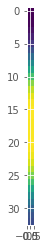

In [ ]:
plt.imshow(U[1].detach().numpy())

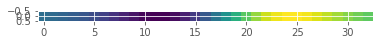

In [ ]:
plt.imshow(V[0].detach().numpy())

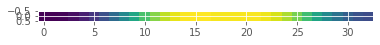

In [ ]:
plt.imshow(V[1].detach().numpy())

In [ ]:
A, S, B = np.linalg.svd(X_hat)

In [ ]:
S

array([3.79900512e-02, 6.85273008e-03, 2.94602071e-08, 7.30812571e-09,
       4.03141911e-10, 3.67073148e-10, 3.46420968e-10, 3.21887874e-10,
       2.82681336e-10, 2.58897478e-10, 2.38865971e-10, 1.96833013e-10,
       1.86341320e-10, 1.62540700e-10, 1.53904974e-10, 1.46058940e-10,
       1.09673924e-10, 8.61944939e-11, 8.10321044e-11, 7.23862488e-11,
       6.47659433e-11, 5.62407534e-11, 4.78117113e-11, 4.09659603e-11,
       2.70946056e-11, 2.09812176e-11, 2.03516667e-11, 1.83721942e-11,
       1.23901144e-11, 4.79932560e-12, 4.54667606e-12, 1.48310688e-12,
       4.75261009e-13])

Text(0.5, 1.0, 'Plot of singular values')

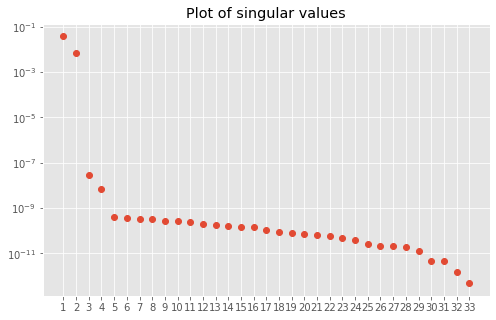

In [ ]:
import matplotlib.pyplot as plt

DEFAULT_FIGSIZE = (8, 5)

plt.figure(figsize=DEFAULT_FIGSIZE)

plt.plot(np.arange(1, len(S) + 1), S, "o")
plt.xticks(np.arange(1, len(S) + 1))
plt.yscale("log")
plt.title("Plot of singular values")


Text(0.5, 1.0, 'Plot of singular values')

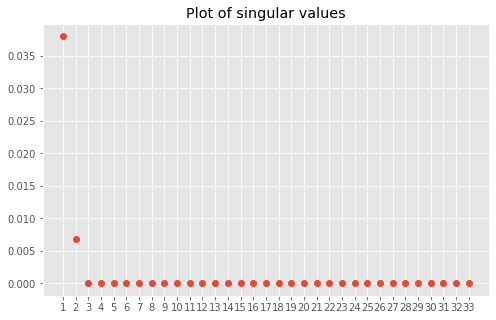

In [ ]:
import matplotlib.pyplot as plt

DEFAULT_FIGSIZE = (8, 5)

plt.figure(figsize=DEFAULT_FIGSIZE)

plt.plot(np.arange(1, len(S) + 1), S, "o")
plt.xticks(np.arange(1, len(S) + 1))
#plt.yscale("log")
plt.title("Plot of singular values")

In [ ]:
X_hat.shape

(33, 33)

In [ ]:
t = torch.from_numpy(X_hat)

In [ ]:
_,Sigma,_=torch.svd_lowrank(t, q=4, niter=2, M=None)

Text(0.5, 1.0, 'Plot of singular values')

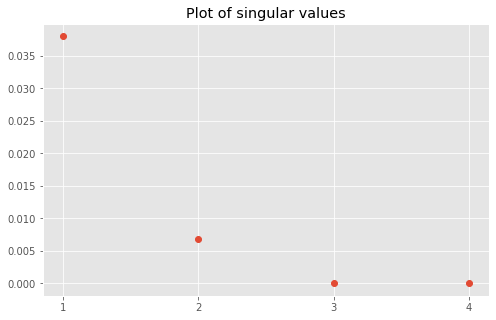

In [ ]:
import matplotlib.pyplot as plt

DEFAULT_FIGSIZE = (8, 5)

plt.figure(figsize=DEFAULT_FIGSIZE)

plt.plot(np.arange(1, len(Sigma) + 1), Sigma, "o")
plt.xticks(np.arange(1, len(Sigma) + 1))
#plt.yscale("log")
plt.title("Plot of singular values")

In [ ]:
def my_outer(U, V):
  My_UV=[]
  for i in range(4):
    UV=np.outer(U[i], V[i])
    My_UV.append(UV) 
  return My_UV

Outer=my_outer(U, V)

Text(0.5, 1.0, 'Fourth channel kernel')

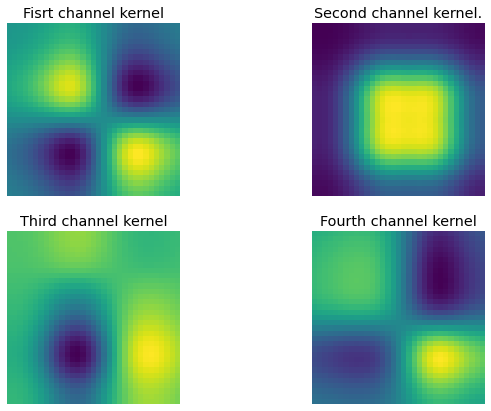

In [ ]:
# code for displaying multiple images in one figure
  
#import libraries
import cv2
from matplotlib import pyplot as plt
  
# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 2
columns = 2
  
# reading images
kern1 = Outer[0]
kern2 = Outer[1]
kern3 = Outer[2]
kern4 = Outer[3]
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(kern1)
plt.axis('off')
plt.title("Fisrt channel kernel")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(kern2)
plt.axis('off')
plt.title("Second channel kernel.")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(kern3)
plt.axis('off')
plt.title("Third channel kernel")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(kern4)
plt.axis('off')
plt.title("Fourth channel kernel")

Text(0.5, 1.0, 'original')

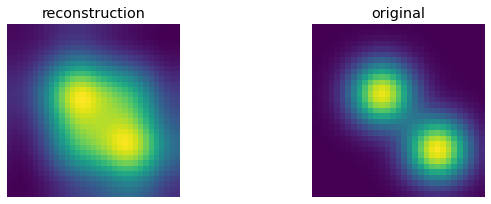

In [ ]:
# code for displaying multiple images in one figure
  
#import libraries
import cv2
from matplotlib import pyplot as plt
  
# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 2
columns = 2
  
# reading images
Image1 = X_hat
Image2 = x1+x2

  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("reconstruction")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("original")



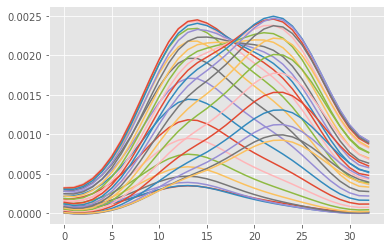

In [ ]:
plt.plot(X_hat)